In [1]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.8

import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
import matplotlib.pyplot as plt
from jax import random
from scipy.linalg import circulant
from jax import grad, jit, vmap, value_and_grad
import optax
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

import os
import sys

file = open("../../../../meta.txt")
home = file.read().replace("\n", "/")
file.close()
    
p = os.path.abspath(home+'mypylib')
if p not in sys.path:
    sys.path.append(p)

import chunGP as gp

def loadData(dataName,N,P,seed=0):
    np.random.seed(seed)

    All=True
    if dataName=='MNIST':
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getMNIST(N_train=N,N_test=100,normalize=True,seed=seed,All=All)
    if dataName=='Fashion':
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getFashion(N_train=N,N_test=100,normalize=True,seed=seed,All=All,home=home)
    if dataName=='CIFAR':
        grayscale=False
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getCIFAR(N_train=N,N_test=100,normalize=True,seed=seed,grayscale=grayscale,All=All,home=home)
    if dataName=='CIFARG':
        grayscale=True
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getCIFAR(N_train=N,N_test=100,normalize=True,seed=seed,grayscale=grayscale,All=All,home=home)
    X=X/np.sqrt(np.sum(np.square(X),axis=1))[:,None]

    train_idx=np.random.choice(np.arange(N),P,replace=False)

    train_ID=np.ones(N)==0
    train_ID[train_idx]=True
    test_ID=np.invert(train_ID)

    x_train=X[train_ID,:]
    x_test=X[test_ID,:]

    y_train=Y[train_ID,:]
    y_test=Y[test_ID,:]
    
    return X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID



env: XLA_PYTHON_CLIENT_MEM_FRACTION=.8


In [2]:
@jit
def accuracy(y_pred,y):
    return jnp.mean(y_pred == y)
def getNN(yr_test,y_class):
    pdist=pairwise_distances(yr_test, y_class, metric='euclidean')
    tp_test=jnp.argmin(pdist,axis=1)
    return y_class[tp_test,:],tp_test
def getMax(yr_test):
    tp_test=jnp.argmax(yr_test,axis=1)
    return tp_test
    
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale/jnp.sqrt(m) * random.normal(w_key, (m,n)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key,scale=1e-2):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k,scale=scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def ReLU(A,quad=True):
    if quad:
        return jnp.square(A) 
    else:
        return jnp.where(A>0,A,0)

def predict(params, X, pa=0,quad=True):
    # per-example predictions
    XL = X
    for W,b in params[:-1]:
        H = jnp.matmul(XL, W)
        b=jnp.quantile(H,1-pa,axis=1)
        XL = ReLU(H-b[:,None],quad=quad)
        #XL = ReLU(H-b,quad=quad)
    final_W = params[-1][0]
    return jnp.matmul(XL, final_W)

def predictL(params, X, pa, L,quad=True):
    # per-example predictions
    XL = X
    for i in range(L):
        W,b=params[i]
        H = jnp.matmul(XL, W)
        b=jnp.quantile(H,1-pa,axis=1)
        XL = ReLU(H-b[:,None],quad=quad)
        #XL = ReLU(H-b,quad=quad)
    return jnp.squeeze(XL)

def predictLast(params, X, pa,quad=True):
    # per-example predictions
    XL = X
    for W,b in params[:-1]:
        H = jnp.matmul(XL, W)
        b=jnp.quantile(H,1-pa,axis=1)
        XL = ReLU(H-b[:,None],quad=quad)
        #XL = ReLU(H-b,quad=quad)
    return XL

def predict_all_layers(params, X, pa=0,quad=True):
    # per-example predictions
    XL = X
    XLs = []
    XLs.append(XL)
    for W,b in params[:-1]:
        H = jnp.matmul(XL, W)
        b=jnp.quantile(H,1-pa,axis=1)
        XL = ReLU(H-b[:,None],quad=quad)
        #XL = ReLU(H-b,quad=quad)
        XLs.append(XL)
    final_W = params[-1][0]
    XLs.append(jnp.matmul(XL, final_W))
    return XLs

def fiterror(params, pa, X, Y,quad=True):
    Yp = predict(params, X, pa,quad=quad)
    return jnp.mean(jnp.square(Y-Yp))

def regf(params,factor,l2=True):
    if l2:
        return factor*sum(jnp.mean(jnp.square(W)) for W,b in params)
    else:
        return factor*sum(jnp.mean(jnp.abs(W)) for W,b in params)

def getlossf(X, Y, pa, factor,quad=True, l2=True):
    def lossf(params):
        return fiterror(params, pa, X, Y,quad=quad) + regf(params,factor,l2=l2) 
    return jit(lossf)

def getosig(tau):
    I0=gp.I2(np.array([0]),np.array([tau]),n=10000)
    osig=np.sqrt(np.pi/(I0-tau*np.sqrt(2*np.pi)))
    return osig

def getXfun(params,pa,L,returnOne=False,neuronID=0,quad=True):
    def Xfun(X):
        return jnp.squeeze(predictL(params, X, pa, L,quad=quad))
    def XfunOne(X):
        return jnp.squeeze(predictL(params, X, pa, L,quad=quad)[neuronID])
        #xvals=predictL(params, X, pa, L)
        #return xvals[neuronID]- jnp.mean(jnp.delete(xvals, neuronID, 0))
    if returnOne:
        return XfunOne
    else:
        return Xfun
        


In [32]:
def trainNN(dataName='MNIST',pa=0.5,P=1000,wwidth=1000,factor=0,layer_sizes=[1,10,1],step_size=1e-3,numit=4000,quad=True,l2=True):
    N=2*P
    seed=0
    X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed)

    nin=np.shape(x_train)[1]
    nout=np.shape(y_train)[1]

    #pa=0.499#35

    #scale=10#2.0
    #scale=getosig(gp.getTau(pa))
    scale=1

    np.random.seed(0)
    params=init_network_params(layer_sizes, random.PRNGKey(np.random.randint(0,1000)),scale=scale)


    XL=predictLast(params, x_train, pa,quad=quad)
    #print(np.shape(params[-1][0]))
    params[-1][0]=jnp.matmul(jnp.matmul(XL.T,jnp.linalg.pinv(jnp.matmul(XL,XL.T))),y_train)

    print(fiterror(params, pa, x_test, y_test,quad=quad))
    loss=getlossf(x_train, y_train, pa, factor,quad=quad,l2=l2)
    lossgrad=grad(loss)

    step_size=step_size
    optimizer = optax.adam(step_size)
    opt_state = optimizer.init(params)

    numit=numit
    #numit=2000
    ge=[]
    for i in range(numit):
        wgrads = lossgrad(params)
        updates, opt_state = optimizer.update(wgrads,opt_state)
        params = optax.apply_updates(params, updates)
        #updates, opt_state = optimizer.update([wgrads,bgrad],opt_state)
        #params,biases = optax.apply_updates([params,biases], updates)

        #params = update(lossgrad,params, biases, step_size=step_size)
        get=fiterror(params, pa, x_test, y_test)
        ge.append(get)
        print('\r{:.2f}, err:{:.4e}'.format(i/numit,get),end='')

    ge=np.array(ge)
    print(get)

    fig,ax=plt.subplots(1,1,figsize=(5,3))
    ax.plot(ge)
    ax.set_yscale('log')

    fig,ax=plt.subplots(1,1,figsize=(5,3))
    ax.plot(np.abs(np.diff(ge)))
    ax.set_yscale('log')

    return params


Download complete.
Save complete.
# of training images:60000
# of test images:10000
Download complete.
Save complete.
# of training images:60000
# of test images:10000


TypeError: 'tuple' object does not support item assignment

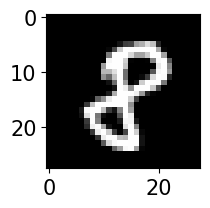

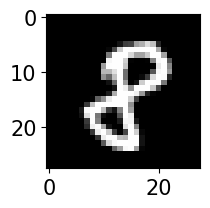

In [33]:
from jax import jacfwd, jacrev
import os

dataNames=['MNIST','Fashion','CIFAR','CIFARG']



numit=5000
factor=0#1e-3
step_size=5e-4


dni=0 
dataName=dataNames[dni]

###
P=100
N=2*P
seed=0
X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed)

nin=np.shape(x_train)[1]
nout=np.shape(y_train)[1]
####

wwidth=1000

layer_sizes = [nin,wwidth,wwidth,nout]

quad0=False
quad1=False


# Model 1
l2=True
pa0=0.5
params0=trainNN(dataName=dataName,numit=numit,l2=l2,pa=pa0,P=P,wwidth=wwidth,factor=factor,layer_sizes=layer_sizes,quad=False,step_size=step_size)
#params0=init_network_params(layer_sizes, random.PRNGKey(np.random.randint(0,1000)),scale=1)

# Model 2
l2=True
pa1=0.1
params1=trainNN(dataName=dataName,numit=numit,l2=l2,pa=pa1,P=P,wwidth=wwidth,factor=factor,layer_sizes=layer_sizes,quad=False,step_size=step_size)



Download complete.
Save complete.
# of training images:60000
# of test images:10000


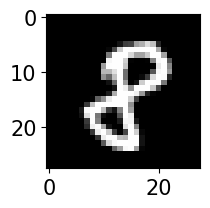

In [148]:
def ReLU(A): return jnp.where(A>0,A,0)

def predictHidden(W, X, pa):
    # per-example predictions
    H = jnp.matmul(X, W)
    b=jnp.quantile(H,1-pa,axis=1)
    Phi = ReLU(H-b[:,None])
    return Phi

def random_layer_params(m, n, key, scale=1e-2):
    #scale=1/m
    w_key, _ = random.split(key)
    return scale/jnp.sqrt(m) * random.normal(w_key, (m, n))#, scale * random.normal(b_key, (n,))

@jit
def trainLast(XL,y_train,s0):
    return jnp.matmul(jnp.matmul(XL.T,jnp.linalg.inv(jnp.matmul(XL,XL.T)+s0*jnp.eye(jnp.shape(y_train)[0]))),y_train)
    #return jnp.matmul(jnp.matmul(XL.T,jnp.linalg.pinv(jnp.matmul(XL,XL.T))),y_train)
    #return jnp.matmul(jnp.linalg.pinv(XL),y_train)


dataNames=['MNIST','Fashion','CIFAR','CIFARG']

dataName = dataNames[0]

N=1000
P=500
seed=0
X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed)

#Lmax=19
#layer_sizes=[np.shape(x_train)[1]]+[wwidth for i in range(Lmax-1)]+[np.shape(y_train)[1]]
#init_network_params_save(layer_sizes, random.PRNGKey(0),scale=1)
    
#dataName=dataNames[-2]
#N=Ns[4]
#P=Ps[4]


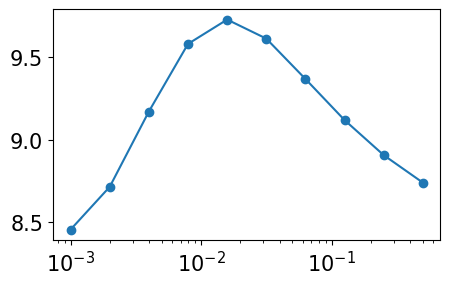

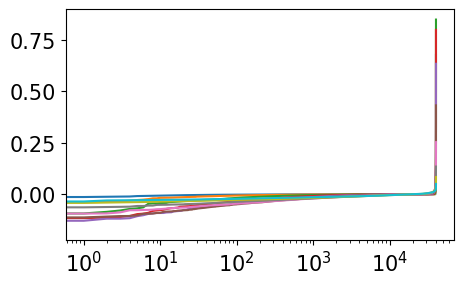

In [149]:
def ED(x): return np.square(np.sum(x))/np.sum(np.square(x))

wwidth=40000
s0=1


keys = random.split(random.PRNGKey(0), 1)
W=random_layer_params(np.shape(X)[1],wwidth, keys[0], scale=1)

#pas=np.linspace(1e-3,1,20)
poweru=np.log(0.5)/np.log(10)
pas=np.power(10,np.linspace(-3,poweru,10))


EDs=[]
As=[]
for pa in pas:
    Phi=predictHidden(W, x_train, pa)

    A=trainLast(Phi,y_train,s0)
    _,s,_=jnp.linalg.svd(A)
    As.append(np.sort(A[:,0]))
    EDs.append(ED(s))
    
fig,ax=plt.subplots(1,1,figsize=(5,3))
ax.plot(pas,EDs,'-o')
ax.set_xscale('log')

As=np.array(As)
fig,ax=plt.subplots(1,1,figsize=(5,3))
ax.plot(As.T);
ax.set_xscale('log')


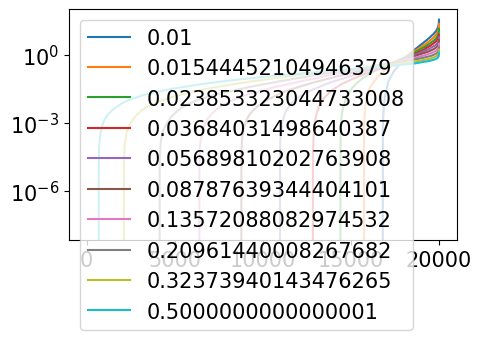

In [126]:
fig,ax=plt.subplots(1,1,figsize=(5,3))
for i,pa in enumerate(pas):
    ax.plot(np.sort(np.abs(As.T)[:,i],axis=0),label=pa);
ax.set_yscale('log')
ax.legend()


In [119]:
np.shape(As)

(30, 20000)